In [2]:
# Declaring path variables to make Basemap work in jupyter hub. Make sure that the conda environment path matches yours
import os
os.environ['PATH'] = '/home/jovyan/my-conda-envs/qiime2-2019.1/bin:' + os.environ['PATH']
os.environ['PROJ_LIB'] = '/home/jovyan/my-conda-envs/qiime2-2019.1/share/proj'

In [3]:
# General Tool Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.basemap import Basemap
import biota
import biota.plot as bpl
import seaborn as sns
import collections
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import math

from biota.database import (get_samples,
                            get_sample_data,
                            get_pg_connection,
                            get_data)
from biota.util import (rarefy,
                        make_tree,
                        get_dms,
                        filter_dm_and_map,
                        get_tax_table)
from IPython.core.display import display, HTML
from pickle import dump, load

import lasio

# SQL Query imports
from sqlalchemy import create_engine, engine, inspect

from functools import partial

from ipyparallel import Client
from sourcetracker import gibbs

# Clustering imports
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy
from skbio.stats.ordination import pcoa

from biota.util import assign_formations


%matplotlib inline

In [4]:
ProdData = pd.read_csv('Prod_4H.csv')

In [5]:
ProdData.head()

,Date,hours,Elasped Time,Choke,THP,WHP,Gas Rate,Oil Rate,Water Rate
0,9/30/2018 0:00:00,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0
1,11/15/2018 0:00:00,1104.0,1104.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11/16/2018 0:00:00,24.0,1128.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11/17/2018 0:00:00,24.0,1152.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11/18/2018 0:00:00,24.0,1176.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
ProdData['WC'] = ProdData['Water Rate'] / (ProdData['Oil Rate'] +ProdData['Water Rate'] )
ProdData['WC'] = ProdData['WC'].fillna(0)


#ax = sns.lineplot(x="Elasped Time", y="Oil Rate", data=ProdData)

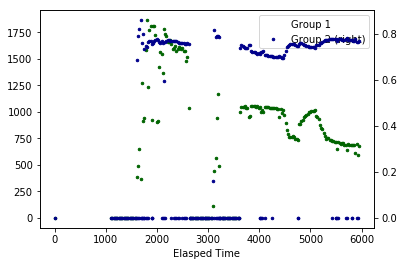

In [51]:
ax = ProdData.plot(kind='line', x='Elasped Time', y='Oil Rate',
                   color='DarkGreen',style='.',markersize=5, label='Group 1');

ProdData.plot(kind='line', x='Elasped Time', y='WC',
              color='DarkBlue',style='.',markersize=5, label='Group 2', secondary_y=True, ax=ax);

In [17]:
SampleDates = pd.read_csv('APC Sample Da.csv')

In [18]:
SampleDates.head()

,wellname,collectiondate,wellapi,welluuid,fieldsampletype,fieldsampleuuid,bridge_id,sequencesampleuuid,sequencingrunid,sequencinggroup
0,silvertip.76.7.unit.a.2h,8/30/2018,4.230130e+13,a8ed5c1b-b28b-4c42-8ab6-6aebb0fc4b5b,produced.fluid,32364227-00ce-4f5e-b9d5-3795320fcb5f,86331.0,009c98a1-2f45-4446-8d6e-ce11b098a16d,20181018_1,72
1,silvertip.76.7.unit.a.2h,8/30/2018,4.230130e+13,a8ed5c1b-b28b-4c42-8ab6-6aebb0fc4b5b,produced.fluid,8dfbeab4-8bee-468e-97d2-de23f788751a,86332.0,988b4414-cd8a-40b2-8c2a-d2c3762bb297,20181018_1,72
2,silvertip.76.7.unit.a.2h,8/30/2018,4.230130e+13,a8ed5c1b-b28b-4c42-8ab6-6aebb0fc4b5b,produced.fluid,47a4acf5-1e9c-4dc9-a384-705e2ae55477,86333.0,8d8ab58a-3670-4144-b8bc-2db35a7b8a69,20181018_1,72
3,silvertip.76.7.unit.a.2h,8/30/2018,4.230130e+13,a8ed5c1b-b28b-4c42-8ab6-6aebb0fc4b5b,produced.fluid,05d256cc-bdf3-4440-98d0-3ab09b346bb4,86334.0,98671e62-de30-45c9-8e8b-175d00e381f5,20181018_1,72
4,silvertip.76.7.unit.a.2h,8/30/2018,4.230130e+13,a8ed5c1b-b28b-4c42-8ab6-6aebb0fc4b5b,produced.fluid,2e21fa8b-97f4-4dd0-9896-9d6bb5419aaf,86335.0,602ed0cf-a282-488f-8215-11fc53ad88a4,20181018_1,72


In [25]:
WellDates = SampleDates.groupby('wellname')['collectiondate'].unique()

In [40]:
df_col = pd.DataFrame()

for i in WellDates:
    print(i)

['12/12/2018' '1/9/2019' '1/17/2019' '1/30/2019' '3/12/2019' '3/19/2019'
 '3/21/2019' '4/4/2019' '4/17/2019' '4/23/2019' '4/30/2019' '5/6/2019'
 '5/15/2019' '5/20/2019' '5/29/2019']
['11/1/2018' '11/8/2018' '12/5/2018' '12/19/2018' '2/14/2019' '3/5/2019'
 '3/19/2019' '5/6/2019' '5/15/2019' '5/20/2019' '5/29/2019']
['8/30/2018' '9/25/2018' '10/23/2018' '12/19/2018' '1/14/2019' '5/6/2019'
 '5/15/2019' '5/20/2019' '5/29/2019']
['9/25/2018' '10/23/2018' '11/1/2018' '12/5/2018' '12/19/2018' '2/14/2019'
 '3/5/2019' '5/6/2019' '5/15/2019' '5/20/2019' '5/29/2019']
['12/12/2018' '3/12/2019' '3/19/2019' '3/21/2019' '4/4/2019' '4/17/2019'
 '4/23/2019' '4/30/2019' '5/6/2019' '5/15/2019' '5/20/2019' '5/29/2019']
['10/23/2018' '11/8/2018' '12/5/2018' '1/14/2019' '1/17/2019' '1/31/2019'
 '3/12/2019' '3/19/2019' '4/17/2019' '4/23/2019' '4/30/2019' '5/6/2019'
 '5/15/2019' '5/20/2019' '5/29/2019']
['1/17/2019' '3/12/2019' '3/19/2019' '3/21/2019' '4/4/2019' '4/17/2019'
 '4/23/2019' '4/30/2019' '5/6/2019'

In [37]:
WellDates

wellname
silvertip.76.7.unit.a.10h    [12/12/2018, 1/9/2019, 1/17/2019, 1/30/2019, 3...
silvertip.76.7.unit.a.1h     [11/1/2018, 11/8/2018, 12/5/2018, 12/19/2018, ...
silvertip.76.7.unit.a.2h     [8/30/2018, 9/25/2018, 10/23/2018, 12/19/2018,...
silvertip.76.7.unit.a.3h     [9/25/2018, 10/23/2018, 11/1/2018, 12/5/2018, ...
silvertip.76.7.unit.a.4h     [12/12/2018, 3/12/2019, 3/19/2019, 3/21/2019, ...
silvertip.76.7.unit.a.5h     [10/23/2018, 11/8/2018, 12/5/2018, 1/14/2019, ...
silvertip.76.7.unit.a.6h     [1/17/2019, 3/12/2019, 3/19/2019, 3/21/2019, 4...
silvertip.76.7.unit.a.7h     [12/5/2018, 12/12/2018, 1/14/2019, 1/17/2019, ...
silvertip.76.7.unit.a.8h     [10/23/2018, 11/1/2018, 11/8/2018, 12/5/2018, ...
silvertip.76.7.unit.a.9h     [12/5/2018, 12/12/2018, 12/18/2018, 1/17/2019,...
silvertip.76.7.unit.b.2h     [1/9/2019, 1/17/2019, 3/12/2019, 3/21/2019, 4/...
silvertip.76.7.unit.b.3h     [1/9/2019, 1/17/2019, 3/12/2019, 3/19/2019, 3/...
Name: collectiondate, dtype: object